# Econophysics and Sociophysics
Authors:

- Rofhiwa (Ralph) Matumba

## Model training

In [255]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import yfinance as yf

from datetime import timedelta, datetime

In [256]:
import os

path = './figures/LR'

if not os.path.exists(path):
    os.makedirs(path)

In [257]:
# Plotting styling parameters

matplotlib.rcParams['font.family'] = 'serif'

### Data loading and visualisation

In this example, we are reading in stocks from an example company.

In [258]:
stocks = ['ABG.JO', 'CLS.JO', 'WHL.JO'] # Stock tickers
stock = stocks[2]
data = yf.download(stock)
data = data[data.index <= datetime(2023, 12, 22)] # Cut off on 22 Dec 2023

c:\Users\rofhi\source-code\env\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


Before we start using this data to make predictions from it, we will just display the last five data entries with column names so that we understand the structure of the data. As of downloading this dataset, the latest close was on the 1st of December 2023.

In [259]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-18,7018.0,7198.0,6872.0,6915.0,6915.0,4229188
2023-12-19,6915.0,6958.0,6791.0,6946.0,6946.0,1621844
2023-12-20,6801.0,7019.0,6876.0,6925.0,6925.0,780035
2023-12-21,7009.0,7033.0,6795.0,6959.0,6959.0,5702057
2023-12-22,7050.0,7119.0,6928.0,7026.0,7026.0,616577


To be able to train models, we will need to look at trading models based on the day before. So we will add lag columns that contain relevant stock prices from the day before. We will also drop the 'Adj. Close' column because it is the same as the 'Close' column for the most part.

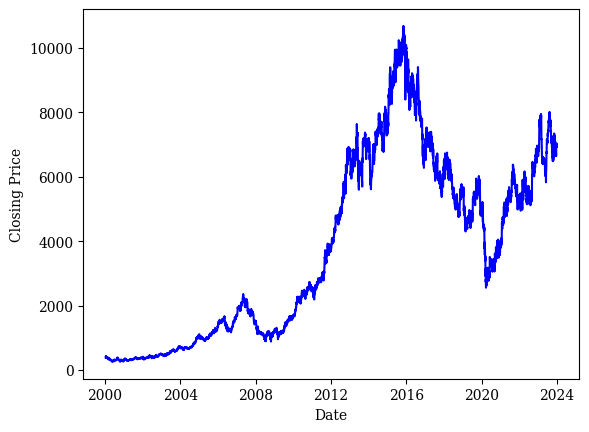

Data ranges from 2000-01-17 00:00:00 to 2023-12-22 00:00:00


In [260]:
plt.plot(data.index, data.get('Close'), c='blue')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.savefig(f'figures/{stock}_chart.svg')
plt.show()

print(f"Data ranges from {data.index[0]} to {data.index[-1]}")

### Data preprocessing

In [261]:
data["Close_L"] = data["Close"].shift(1)

# Drop 'Adj Close' column and NaN columns
data = data.drop("Adj Close", axis=1)
data = data.dropna()

C:\Users\rofhi\AppData\Local\Temp\ipykernel_8596\3697970945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Close_L"] = data["Close"].shift(1)


In [262]:
data.tail()

,Open,High,Low,Close,Volume,Close_L
Date,,,,,,
2023-12-18,7018.0,7198.0,6872.0,6915.0,4229188,7031.0
2023-12-19,6915.0,6958.0,6791.0,6946.0,1621844,6915.0
2023-12-20,6801.0,7019.0,6876.0,6925.0,780035,6946.0
2023-12-21,7009.0,7033.0,6795.0,6959.0,5702057,6925.0
2023-12-22,7050.0,7119.0,6928.0,7026.0,616577,6959.0


### Data split

In [263]:
features = ["Close_L"]
targets = ["Close"]

X = data[features]
y = data[targets]

### Train-test split

In [264]:
def train_test_split(X, y, test_size):
    ind = int(len(y) - test_size * len(y))

    X_train, y_train = X[:ind], y[:ind]
    X_test, y_test = X[ind:], y[ind:]

    return X_train, y_train, X_test, y_test

In [265]:
test_size = 0.2
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=test_size)

### Model fitting

In [266]:
# Initialize a dictionary to store models and MSE
models = {}
mae_results = {}
pred = []

# Train separate models for each target variable in a for loop
for column in y.columns:

    model = LinearRegression()
    # Train the model
    model.fit(X_train, y_train[column])
    
    # Make predictions on the test set
    predictions = model.predict(X_test)
    pred.append(predictions)
    
    # Store the model and predictions
    models[column] = model
    mae_results[column] = mean_absolute_error(y_test[column], predictions)

# Print the MSE for each target variable
for column, mae in mae_results.items():
    print(f'Mean Absolute Error - {column}: {mae}')

pred = pd.DataFrame(np.array(pred).T)
pred.columns = targets
pred = pred.set_index(pd.Index(data.index[int(len(y) - test_size * len(y)):] + timedelta(days=1)))

Mean Absolute Error - Close: 78.08991399613814


## Model testing

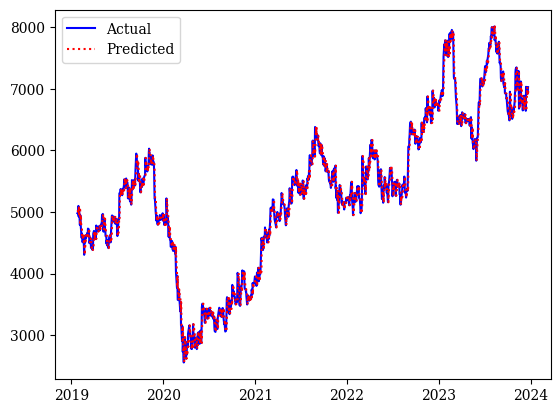

In [267]:
plt.plot(X_test.index, y_test, c='blue')
plt.plot(pred.index, pred.get('Close'), ':', c='red')
plt.legend(['Actual', 'Predicted'])
plt.savefig(f'{path}/{stock}_pred_vs_true.svg')

In [268]:
lag = [list(pred.iloc[-1])]  # Assuming 'Close Price' is the target column
num_days = 7  # Forecast 7 days

for day in range(num_days):
    day_pred = []
    for column in range(len(targets)):
        val = np.array(lag[-1][column]).reshape(1, -1)
        col = targets[column]
        prediction = float(models[col].predict(val))
        day_pred.append(prediction)

    # Update the 'Close Price - 1 day' value in the lag list for the next iteration
    lag.append(day_pred)

c:\Users\rofhi\source-code\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\rofhi\source-code\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\rofhi\source-code\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\rofhi\source-code\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\rofhi\source-code\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\rofhi\source-code\env\Lib\site-packages\sklearn\bas

In [269]:
lag = pd.DataFrame(lag, columns=targets)
new_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=num_days + 1, freq='D')
lag.set_index(new_index, inplace=True)

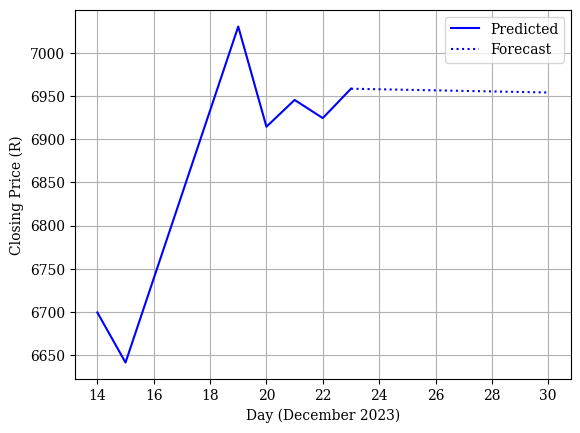

In [270]:
pred = pred.iloc[-7:]

plt.plot([day.day for day in pred.index], pred.get('Close'), c='blue')
plt.plot([day.day for day in lag.index], lag.get('Close'), ':', c='blue')
plt.grid('True')
plt.xlabel('Day (December 2023)')
plt.ylabel('Closing Price (R)')
plt.legend(['Predicted', 'Forecast'])
plt.savefig(f'{path}/{stock}_forecast.svg')